# Air Quality from Frankfurt<a id='top'></a>
## Contents <a id='top'></a>
1. <a href=#intro>Introduction</a>
    1. <a href=#back>Background</a>
    1. <a href=#object>Objective</a>
1. <a href=#data>Data exploration</a>
1. <a href=#model>Modeling</a>
    1. <a href=#regression>Simple Regression</a>
    1. <a href=#ts>Regression with Time Series</a>
    1. <a href=#cm>Classification Model</a>
    1. <a href=#clustering>Clustering Model</a>
    1. <a href=#tsa>Time Series analysis</a>
1. <a href=#conclusion>Conclusion</a>
1. <a href=#ref>Links</a>

In [1]:
from datetime import datetime as dt 
import numpy as np
import pandas as pd
from numpy.random import default_rng
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import folium
%matplotlib inline
from folium import plugins
import datetime, calendar
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import acf
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns

<a id='intro'></a>
# 1. Introduction
<a href=#top>(back to top)</a>

<a id='back'></a>
## 1.1 Background
With the rapid development of economy and the continuous improvement of industrialization and urbanization, air pollution is becoming more and more serious. The pollution of PM2.5 is more serious, and haze weather occurs frequently, which causes serious adverse effects on the atmospheric environment and human health, which has aroused widespread concern in the world. 

<a id='object'></a>
## 1.2 Objective
Based on the monitoring data of Frankfurt area, the PM2.5 concentration in the air of the area was studied in detail. The monitoring data were preprocessed and a variety of models were established. The correlation between PM2.5 concentration and other environmental factors was obtained.

<a id='data'></a>
# 2. Data exploration
<a href=#top>(back to top)</a>

For this project the dataset is downloaded from Kaggle.com, a website which is known as a machine learning and data analytics competition platform. It contains 14 columns in total, and there are more than 1200000 observations in this dataset.

Attribute information:
1. Time_stamp: timing records with internal of 3 min from 2018/12/31 to 2020/2/28
2. boxName: categorical variables with 14 different sensors:'iGude','Rothschildallee' etc.
3. PM 2.5: the value of PM 2.5 for a certain time collected by certain sensor.
4. temp: the temperature for a certain time at the place of certain sensor.
5. pressure: the pressure for a certain time at the place of certain sensor.
6. humidity: the humidity for a certain time at the place of certain sensor.
7. wind_speed: the speed of wind for a certain time at the place of certain sensor.
8. Time of Day: the time period of a day for the observations. 4 categories: morining, afternoon, evening, night.
9. Peak/NoPeak: determine whether it is a peak time of the day or not.
10. Day: determine what day it is. Monday-Sunday.
11. Week Day: determine whether it is a workday or a weekend.
12. Weather: determine what the weather is for a certain observation
13. Weather Description: describe what the weather is in detail.
14. label: normal or abnormal.

## 2.1 Loading data

In [2]:
pm = pd.read_csv('../input/air-quality-dataset/Air Quality Benchmark dataset.csv')
pm.head(5)

Time_stamp boxName  PM 2.5  temp  pressure  humidity  wind_speed  \
0  2018-12-31 18:30:12   iGude   18.20  7.71      1032       100        3.09   
1  2018-12-31 18:32:41   iGude   19.27  7.71      1032       100        3.09   
2  2018-12-31 18:35:11   iGude   18.57  7.71      1032       100        3.09   
3  2018-12-31 18:37:41   iGude   17.85  7.71      1032       100        3.09   
4  2018-12-31 18:40:11   iGude   25.95  7.71      1032       100        3.09   

     Time of Day Peak/NoPeak     Day Week Day Weather Weather Description  \
0  Evening_Hours        Peak  Monday  Workday  Clouds       broken clouds   
1  Evening_Hours        Peak  Monday  Workday  Clouds       broken clouds   
2  Evening_Hours        Peak  Monday  Workday  Clouds       broken clouds   
3  Evening_Hours        Peak  Monday  Workday  Clouds       broken clouds   
4  Evening_Hours        Peak  Monday  Workday  Clouds       broken clouds   

    label  
0  normal  
1  normal  
2  normal  
3  normal  
4  normal

In [3]:
# set list of category of all categorical features.
Time_of_day_category=pm['Time of Day'].unique()
peak_category=pm['Peak/NoPeak'].unique()
Day_category=pm['Day'].unique()
Weekday_category=pm['Week Day'].unique()
Weather_category=pm['Weather'].unique()
list_of_category_list=[Time_of_day_category,peak_category,Day_category,Weekday_category,Weather_category]
print(list_of_category_list)

[array(['Evening_Hours', 'Night_Hours', 'Morning_Hours', 'Afternoon_Hours'],
      dtype=object), array(['Peak', 'No_Peak'], dtype=object), array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object), array(['Workday', 'Weekend'], dtype=object), array(['Clouds', 'Mist', 'Fog', 'Rain', 'Drizzle', 'Drizzle + Rain',
       'Clear', 'Snow', 'Snow + Mist', 'Drizzle + Snow + Mist',
       'Drizzle + Rain + Mist', 'Drizzle + Mist', 'Rain + Snow',
       'Rain + Mist', 'Mist + Fog', 'Thunderstorm + Rain', 'Squall',
       'Haze', 'Thunderstorm', 'Thunderstorm + Squall', 'Rain + Fog',
       'Snow + Mist + Fog', 'Snow + Fog'], dtype=object)]


In [4]:
# set list of dictionaries for each categorical features
Time_of_day_dict={}
peak_dict={}
Day_dict={}
Weekday_dict={}
Weather_dict={}
list_of_dict=[Time_of_day_dict,peak_dict,Day_dict,Weekday_dict,Weather_dict]

for j in range(len(list_of_dict)):
    for i,items in enumerate(list_of_category_list[j]):
        list_of_dict[j][i]=items
list_of_dict

[{0: 'Evening_Hours',
  1: 'Night_Hours',
  2: 'Morning_Hours',
  3: 'Afternoon_Hours'},
 {0: 'Peak', 1: 'No_Peak'},
 {0: 'Monday',
  1: 'Tuesday',
  2: 'Wednesday',
  3: 'Thursday',
  4: 'Friday',
  5: 'Saturday',
  6: 'Sunday'},
 {0: 'Workday', 1: 'Weekend'},
 {0: 'Clouds',
  1: 'Mist',
  2: 'Fog',
  3: 'Rain',
  4: 'Drizzle',
  5: 'Drizzle + Rain',
  6: 'Clear',
  7: 'Snow',
  8: 'Snow + Mist',
  9: 'Drizzle + Snow + Mist',
  10: 'Drizzle + Rain + Mist',
  11: 'Drizzle + Mist',
  12: 'Rain + Snow',
  13: 'Rain + Mist',
  14: 'Mist + Fog',
  15: 'Thunderstorm + Rain',
  16: 'Squall',
  17: 'Haze',
  18: 'Thunderstorm',
  19: 'Thunderstorm + Squall',
  20: 'Rain + Fog',
  21: 'Snow + Mist + Fog',
  22: 'Snow + Fog'}]

## 2.2 Preprocessing data
### Check for missing value

In [5]:
pm.replace(to_replace= r'^\s*$', value=np.nan,regex=True, inplace=True ) 
#replace any unit value that only contains " " or space, with 0.
pm.isnull().any() 
#check whether each column contains a missing value

Time_stamp             False
boxName                False
PM 2.5                 False
temp                   False
pressure               False
humidity               False
wind_speed             False
Time of Day            False
Peak/NoPeak            False
Day                    False
Week Day               False
Weather                False
Weather Description    False
label                  False
dtype: bool

From above we can see there is no null value in the dataset, so we can use this dataset straightly.

#### Add longitude and latitude columns
We try to add longitude and latitude columns at the end of dataset for each observation, so that we can do map vasualization for those sensors in different locations.

In [6]:
# after finding the longtitude and latitude values for each sensors, we store them into a dictionary.
place_dict = {
    'iGude':[50.100216, 8.693827],
    'Rothschildallee':[50.127313, 8.696384],
    'FeinstaubFFM':[50.128178, 8.691848],
    'Frankfurt_Riederwald':[50.128679, 8.732761],
    'Medienzentrum Frankfurt':[50.113110, 8.685966],
    'FFM_Westend_Sued':[50.115127, 8.658714],
    'ioki':[50.117625, 8.671350],
    'Ginnheim_Dust_Light_Temp':[50.143277, 8.647729],
    'Alt Bornheim Feinstaub':[50.130067, 8.710821],
    'Bernem':[50.124220, 8.709344],
    'MousonSense':[50.147694, 8.695171]
}

# we also drop those rows with sensors that cannot identify its location.
drop_rows = ['nordsand', 's4', 'Luftdaten.info [6703181]']
for i in drop_rows:
    pm = pm.drop(pm[pm['boxName'] == i].index)

In [7]:
# Convert each text value in categorical feature to numerical value
columns=['Time of Day','Peak/NoPeak','Day','Week Day','Weather','label']

for columns in columns:
    u = pm[columns].unique()
    
    def conver(x):
        return np.argwhere(u==x)[0,0]
    
    pm[columns] = pm[columns].map(conver)

# using a loop to append latitude and longtitude for each observation at the end of dataset.
for k, v in place_dict.items():
    pm.loc[pm['boxName'] == k, 'latitude'] = v[0]
    pm.loc[pm['boxName'] == k, 'longitude'] = v[1]

#### Aggregate timing records
Close scrutiny of the case reveals that there are too many observations among the dataset, and the interval of each observation are so small, so we try to make dataset size smaller. We aggregate timing records with interval of 3 min into interval of one day for each sensor, so some of the columns (PM 2.5 etc)collected by one sensor within one day will be taken average to represent the data of this day by certain sensor, and the rest of columns (weather etc) collected by one sensor within one day will be taken mode to represent the data of this day.

In [8]:
# convert the type of Time_stamp(string) into Timestamp, 
#so that we can straightly use days for that time stamp in the following step.
pm['Time_stamp'] = pd.to_datetime(pm['Time_stamp'])
type(pm.iloc[0]['Time_stamp'])

# Split dataframe by boxName
classification=list(pm['boxName'].unique())
for i in classification:
    pm1=pm[pm['boxName'].isin([i])]
    exec("group%s=pm1"%classification.index(i))

# Process multiple DataFrame data in batches
name=[]
data=[]
for j in range(0,len(classification)):
    dfName='group'+str(j)
    dfData=eval(dfName)
    name.append(dfName)
    data.append(dfData)
data[3].head() # show the splited dataframe where the boxName is Frankfurt_Riederwold.

Time_stamp       boxName  PM 2.5  temp  pressure  humidity  \
404500 2018-12-31 18:31:04  FeinstaubFFM   16.62  7.71      1032       100   
404501 2018-12-31 18:33:32  FeinstaubFFM   17.77  7.71      1032       100   
404502 2018-12-31 18:36:01  FeinstaubFFM   19.00  7.71      1032       100   
404503 2018-12-31 18:38:29  FeinstaubFFM   19.02  7.71      1032       100   
404504 2018-12-31 18:40:59  FeinstaubFFM   18.90  7.71      1032       100   

        wind_speed  Time of Day  Peak/NoPeak  Day  Week Day  Weather  \
404500        3.09            0            0    0         0        0   
404501        3.09            0            0    0         0        0   
404502        3.09            0            0    0         0        0   
404503        3.09            0            0    0         0        0   
404504        3.09            0            0    0         0        0   

       Weather Description  label   latitude  longitude  
404500       broken clouds      0  50.128178   8.691848  
404501       broken clouds      0  50.128178   8.691848  
404502       broken clouds      1  50.128178   8.691848  
404503       broken clouds      1  50.128178   8.691848  
404504       broken clouds      0  50.128178   8.691848

In [9]:
# Average by timestamp: in order to integrate all the data of one day into one value, we take the average for the numerical features
b=[]
for k in range(0,len(classification)):
    a=data[k].groupby(pd.Grouper(key='Time_stamp', freq='1D')).aggregate(np.mean)
    a['boxName']=classification[k]
    columns_total=['boxName','PM 2.5','temp','pressure','humidity','wind_speed', 'latitude', 'longitude']
    a=pd.DataFrame(a,columns=columns_total)
    b.append(a)

# Mode by timestamp: in order to integrate all the data of one day into one value, we take the mode for the categorical features.
d=[]
for l in range(0,len(classification)):
    c=data[l].groupby(pd.Grouper(key='Time_stamp', freq='1D')).aggregate(lambda x: np.max(pd.Series.mode(x)))
    c['boxName']=classification[l]
    columns_total=['boxName','Time of Day','Peak/NoPeak','Day','Week Day','Weather','label']
    c=pd.DataFrame(c,columns=columns_total)
    d.append(c)

# Merge the dataframes
for m in range(1,len(classification)):
    b[m]=pd.concat([b[m-1],b[m]],axis=0)
    d[m]=pd.concat([d[m-1],d[m]],axis=0)
total1=b[10]
total2=d[10]

total1 = total1.reset_index().dropna()
total2 = total2.reset_index().dropna()
total2.head()

Time_stamp boxName  Time of Day  Peak/NoPeak  Day  Week Day  Weather  label
0 2018-12-31   iGude          1.0          1.0  0.0       0.0      0.0    0.0
1 2019-01-01   iGude          1.0          1.0  1.0       0.0      0.0    0.0
2 2019-01-02   iGude          1.0          1.0  2.0       0.0      0.0    0.0
3 2019-01-03   iGude          1.0          1.0  3.0       0.0      0.0    0.0
4 2019-01-04   iGude          1.0          1.0  4.0       0.0      0.0    0.0

In [10]:
total2.loc[:,'Time of Day':'label'] = total2.loc[:,'Time of Day':'label'].astype(int)
total2.head()

Time_stamp boxName  Time of Day  Peak/NoPeak  Day  Week Day  Weather  label
0 2018-12-31   iGude            1            1    0         0        0      0
1 2019-01-01   iGude            1            1    1         0        0      0
2 2019-01-02   iGude            1            1    2         0        0      0
3 2019-01-03   iGude            1            1    3         0        0      0
4 2019-01-04   iGude            1            1    4         0        0      0

In [11]:
total =pd.merge(total1,total2,on=['Time_stamp','boxName'])
total.head()

Time_stamp boxName     PM 2.5      temp     pressure   humidity  wind_speed  \
0 2018-12-31   iGude  77.372782  7.417218  1032.000000  97.473684    3.000000   
1 2019-01-01   iGude  27.835823  6.492166  1027.291161  84.745234    5.102218   
2 2019-01-02   iGude   2.699040  3.186069  1031.262681  63.092391    5.225036   
3 2019-01-03   iGude  10.160219  0.663960  1035.813869  83.593066    2.287920   
4 2019-01-04   iGude  12.142312  1.665520  1034.075269  86.600358    3.149695   

    latitude  longitude  Time of Day  Peak/NoPeak  Day  Week Day  Weather  \
0  50.100216   8.693827            1            1    0         0        0   
1  50.100216   8.693827            1            1    1         0        0   
2  50.100216   8.693827            1            1    2         0        0   
3  50.100216   8.693827            1            1    3         0        0   
4  50.100216   8.693827            1            1    4         0        0   

   label  
0      0  
1      0  
2      0  
3      0  
4      0

In [12]:
total.groupby('boxName').describe()

PM 2.5                                            \
                          count       mean        std       min       25%   
boxName                                                                     
Alt Bornheim Feinstaub     20.0   2.072771   1.189319  0.682438  1.258895   
Bernem                    424.0  10.094273  10.324061  1.234055  4.264786   
FFM_Westend_Sued          141.0   7.241949   7.295398  0.532258  2.137008   
FeinstaubFFM              415.0   6.944039   6.698171  1.392939  2.991296   
Frankfurt_Riederwald      425.0   9.013675   8.867903  0.979982  3.442808   
Ginnheim_Dust_Light_Temp   50.0  10.869147  13.267079  0.610012  2.462999   
Medienzentrum Frankfurt     5.0   1.721740   0.097303  1.637500  1.643836   
MousonSense               396.0   8.604602   9.023369  1.368607  3.499232   
Rothschildallee           415.0   7.011103   7.521387  0.425964  2.737996   
iGude                      22.0  11.162603  16.112956  2.121059  3.871145   
ioki                      142.0   9.784111   9.958113  0.743211  2.845646   

                                                            temp             \
                               50%        75%         max  count       mean   
boxName                                                                       
Alt Bornheim Feinstaub    1.716459   2.537528    5.621444   20.0   6.865825   
Bernem                    6.902829  12.924268  145.066582  424.0  10.750616   
FFM_Westend_Sued          4.626446  10.156296   52.135971  141.0   6.531803   
FeinstaubFFM              4.697325   8.927600   88.481353  415.0  10.867118   
Frankfurt_Riederwald      6.297052  12.318608   94.022575  425.0  10.740345   
Ginnheim_Dust_Light_Temp  4.629698  13.703010   54.917460   50.0   5.229801   
Medienzentrum Frankfurt   1.706250   1.744643    1.876471    5.0  17.218215   
MousonSense               5.896621  11.144668  123.420154  396.0  11.073806   
Rothschildallee           5.128990   9.060292  102.009621  415.0  10.879833   
iGude                     4.983010  11.774789   77.372782   22.0   3.014039   
ioki                      5.569353  12.901842   60.495144  142.0   6.082096   

                          ... Weather        label                           \
                          ...     75%   max  count      mean       std  min   
boxName                   ...                                                 
Alt Bornheim Feinstaub    ...    0.00   6.0   20.0  0.000000  0.000000  0.0   
Bernem                    ...    2.00  11.0  424.0  0.021226  0.144309  0.0   
FFM_Westend_Sued          ...    0.00  11.0  141.0  0.007092  0.084215  0.0   
FeinstaubFFM              ...    1.50  11.0  415.0  0.016867  0.128930  0.0   
Frankfurt_Riederwald      ...    2.00  11.0  425.0  0.014118  0.118115  0.0   
Ginnheim_Dust_Light_Temp  ...    1.75   6.0   50.0  0.020000  0.141421  0.0   
Medienzentrum Frankfurt   ...    3.00   3.0    5.0  0.000000  0.000000  0.0   
MousonSense               ...    1.00  11.0  396.0  0.017677  0.131940  0.0   
Rothschildallee           ...    2.00  11.0  415.0  0.019277  0.137663  0.0   
iGude                     ...    2.25   8.0   22.0  0.000000  0.000000  0.0   
ioki                      ...    0.00  11.0  142.0  0.014085  0.118257  0.0   

                                              
                          25%  50%  75%  max  
boxName                                       
Alt Bornheim Feinstaub    0.0  0.0  0.0  0.0  
Bernem                    0.0  0.0  0.0  1.0  
FFM_Westend_Sued          0.0  0.0  0.0  1.0  
FeinstaubFFM              0.0  0.0  0.0  1.0  
Frankfurt_Riederwald      0.0  0.0  0.0  1.0  
Ginnheim_Dust_Light_Temp  0.0  0.0  0.0  1.0  
Medienzentrum Frankfurt   0.0  0.0  0.0  0.0  
MousonSense               0.0  0.0  0.0  1.0  
Rothschildallee           0.0  0.0  0.0  1.0  
iGude                     0.0  0.0  0.0  0.0  
ioki                      0.0  0.0  0.0  1.0  

[11 rows x 104 columns]

#### Data visualization

In [13]:
total.boxName.unique()

array(['iGude', 'Rothschildallee', 'Bernem', 'FeinstaubFFM',
       'Frankfurt_Riederwald', 'MousonSense', 'Medienzentrum Frankfurt',
       'FFM_Westend_Sued', 'ioki', 'Ginnheim_Dust_Light_Temp',
       'Alt Bornheim Feinstaub'], dtype=object)

In [14]:
print(total.boxName.unique()[0:2],
      total.boxName.unique()[2:5],
      total.boxName.unique()[5:8],
      total.boxName.unique()[8:11])

['iGude' 'Rothschildallee'] ['Bernem' 'FeinstaubFFM' 'Frankfurt_Riederwald'] ['MousonSense' 'Medienzentrum Frankfurt' 'FFM_Westend_Sued'] ['ioki' 'Ginnheim_Dust_Light_Temp' 'Alt Bornheim Feinstaub']


In [15]:
print(total[total.boxName=='Rothschildallee'][-1:].index,
      total[total.boxName=='Frankfurt_Riederwald'][-1:].index,
      total[total.boxName=='FFM_Westend_Sued'][-1:].index,
      total[total.boxName=='Alt Bornheim Feinstaub'][-1:].index)

Int64Index([436], dtype='int64') Int64Index([1700], dtype='int64') Int64Index([2242], dtype='int64') Int64Index([2454], dtype='int64')


In [16]:
total_vis1=total[0:437]
total_vis2=total[437:1701]
total_vis3=total[1701:2243]
total_vis4=total[2243:2455]
total[total.boxName=='Medienzentrum Frankfurt']

Time_stamp                  boxName    PM 2.5       temp     pressure  \
2097 2019-07-09  Medienzentrum Frankfurt  1.643836  18.418767  1018.671233   
2098 2019-07-10  Medienzentrum Frankfurt  1.744643  21.194955  1017.169643   
2099 2019-07-11  Medienzentrum Frankfurt  1.876471  16.934853  1014.529412   
2100 2019-09-25  Medienzentrum Frankfurt  1.637500  14.130000  1009.000000   
2101 2019-09-26  Medienzentrum Frankfurt  1.706250  15.412500  1009.687500   

        humidity  wind_speed  latitude  longitude  Time of Day  Peak/NoPeak  \
2097   39.356164    3.013699  50.11311   8.685966            0            0   
2098   34.169643    2.776339  50.11311   8.685966            3            1   
2099   53.426471    2.694118  50.11311   8.685966            1            1   
2100  100.000000    3.350000  50.11311   8.685966            1            1   
2101   94.312500    3.350000  50.11311   8.685966            1            1   

      Day  Week Day  Weather  label  
2097    1         0        0      0  
2098    2         0        0      0  
2099    3         0        3      0  
2100    2         0        3      0  
2101    3         0        0      0

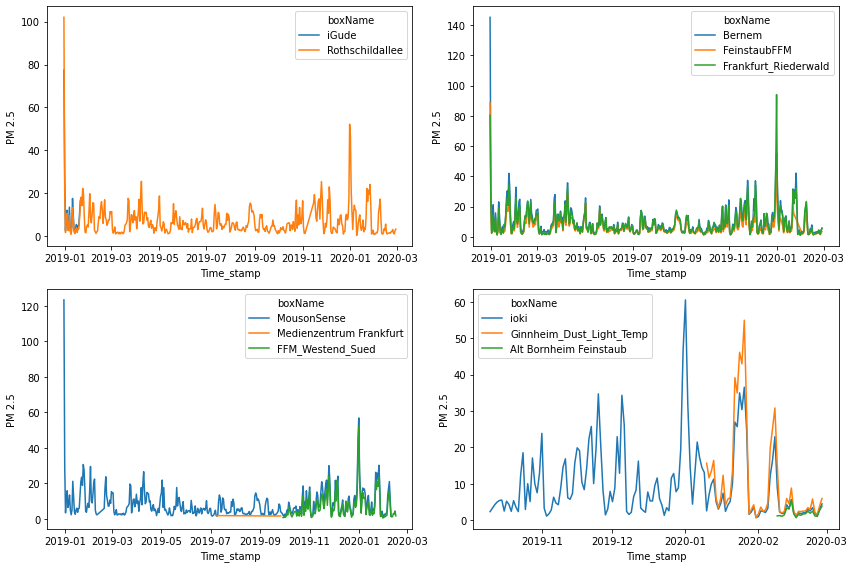

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
sns.lineplot(x="Time_stamp", y="PM 2.5",
             hue="boxName", sizes=0.25, data=total_vis1,ax=ax[0][0])
sns.lineplot(x="Time_stamp", y="PM 2.5",
             hue="boxName", sizes=0.25, data=total_vis2,ax=ax[0][1])
sns.lineplot(x="Time_stamp", y="PM 2.5",
             hue="boxName", sizes=0.25, data=total_vis3,ax=ax[1][0])
sns.lineplot(x="Time_stamp", y="PM 2.5",
             hue="boxName", sizes=0.25, data=total_vis4,ax=ax[1][1])
fig.tight_layout()

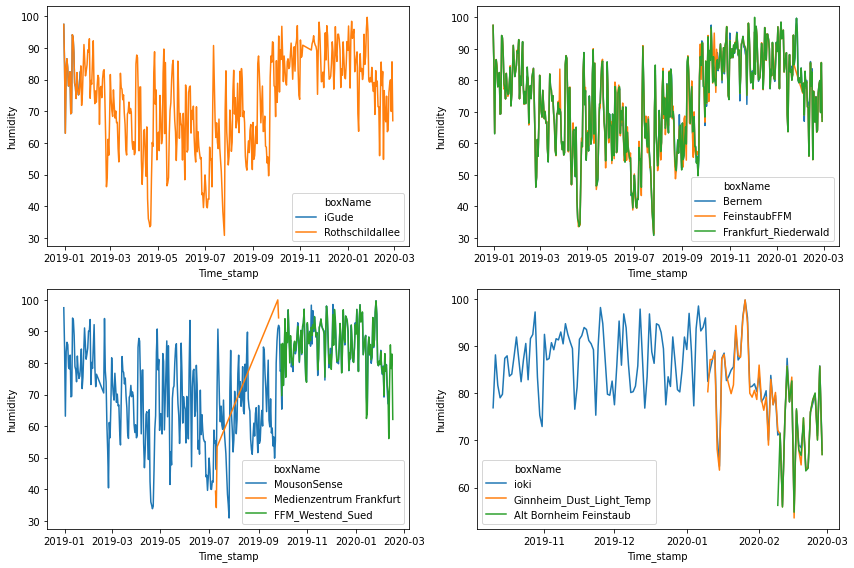

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
sns.lineplot(x="Time_stamp", y="humidity",
             hue="boxName", sizes=0.25, data=total_vis1,ax=ax[0][0])
sns.lineplot(x="Time_stamp", y="humidity",
             hue="boxName", sizes=0.25, data=total_vis2,ax=ax[0][1])
sns.lineplot(x="Time_stamp", y="humidity",
             hue="boxName", sizes=0.25, data=total_vis3,ax=ax[1][0])
sns.lineplot(x="Time_stamp", y="humidity",
             hue="boxName", sizes=0.25, data=total_vis4,ax=ax[1][1])
fig.tight_layout()

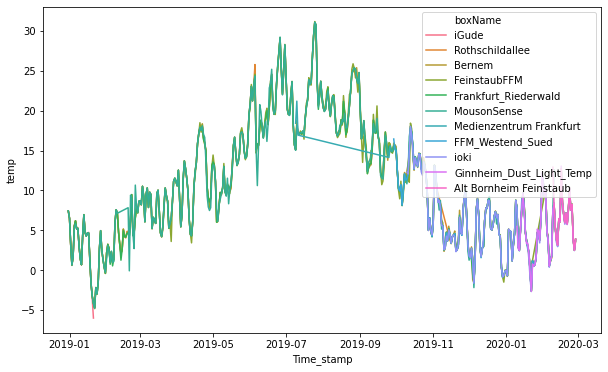

In [19]:
plt.figure(figsize=(10,6))
sns.lineplot(x="Time_stamp", y="temp",
             hue="boxName", data=total)

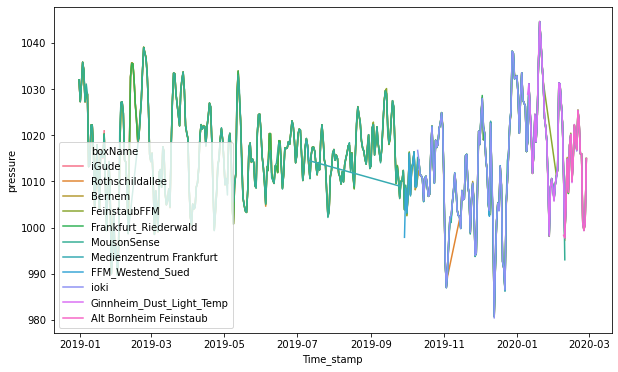

In [20]:
plt.figure(figsize=(10,6))
sns.lineplot(x="Time_stamp", y="pressure",
             hue="boxName", data=total)

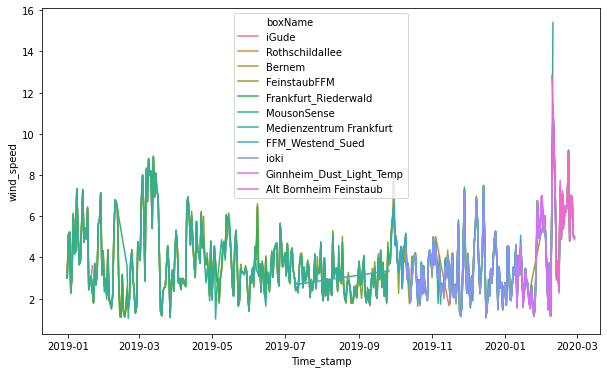

In [21]:
plt.figure(figsize=(10,6))
sns.lineplot(x="Time_stamp", y="wind_speed",
             hue="boxName", data=total)

## 2.3 Map Visualization
### Distribution of number of observations for each sensor on the map

In [22]:
san_map = folium.Map(location = [50.128679, 8.732761], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(san_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(total.latitude, total.longitude, total['PM 2.5']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# add incidents to map
san_map.add_child(incidents)

In [23]:
total.to_csv('processed_data.csv',index=False)

#### visualization of mean value of PM2.5 observed by each sensor

In [24]:
place_name = list(place_dict.keys())
df_place = pd.DataFrame.from_dict(place_dict, orient='index',columns=['latitude', 'longitude'])
df_place

latitude  longitude
iGude                     50.100216   8.693827
Rothschildallee           50.127313   8.696384
FeinstaubFFM              50.128178   8.691848
Frankfurt_Riederwald      50.128679   8.732761
Medienzentrum Frankfurt   50.113110   8.685966
FFM_Westend_Sued          50.115127   8.658714
ioki                      50.117625   8.671350
Ginnheim_Dust_Light_Temp  50.143277   8.647729
Alt Bornheim Feinstaub    50.130067   8.710821
Bernem                    50.124220   8.709344
MousonSense               50.147694   8.695171

In [25]:
pm_mean = pm[pm.boxName.isin(place_name)][['boxName','PM 2.5','latitude','longitude']].groupby('boxName').mean()
pm_mean

PM 2.5   latitude  longitude
boxName                                                  
Alt Bornheim Feinstaub     2.094907  50.130067   8.710821
Bernem                    10.105528  50.124220   8.709344
FFM_Westend_Sued           7.672795  50.115127   8.658714
FeinstaubFFM               7.594132  50.128178   8.691848
Frankfurt_Riederwald       8.812270  50.128679   8.732761
Ginnheim_Dust_Light_Temp  10.452228  50.143277   8.647729
Medienzentrum Frankfurt    1.744987  50.113110   8.685966
MousonSense                8.522746  50.147694   8.695171
Rothschildallee            6.792860  50.127313   8.696384
iGude                      8.678825  50.100216   8.693827
ioki                       9.954842  50.117625   8.671350

In [26]:
colour = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
            'beige', 'darkblue', 'pink', 'cadetblue',
         'darkpurple', 'white', 'lightblue', 'lightgreen',
         'gray', 'black', 'lightgray']

In [27]:
ger_map = folium.Map(location=[50.105, 8.69], zoom_start=12, max_zoom=30)
for i in range(0, len(pm_mean)):
    folium.Circle(location = [pm_mean.iloc[i, 1], pm_mean.iloc[i, 2]], 
                  radius = pm_mean.iloc[i, 0] * 100, 
                  popup = str(pm_mean.index[i]),
                 color = colour[i],
                 fill = True).add_to(ger_map)
ger_map

<a id='model'></a>
# 3. Modeling
<a href=#top>(back to top)</a>

<a id='regression'></a>
## 3.1 Simple Regression
<a href=#top>(back to top)</a>

In [28]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [29]:
X=total.loc[:,('temp','pressure','humidity','wind_speed')]
y=total.loc[:,'PM 2.5']
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=42)
print ('X_train.shape={}\ny_train.shape ={}\nX_test.shape={}\ny_test.shape={}'.format(X_train.shape,y_train.shape,X_test.shape,y_test.shape))

X_train.shape=(1964, 4)
y_train.shape =(1964,)
X_test.shape=(491, 4)
y_test.shape=(491,)


In [30]:
# Define a function that compares the CV perfromance of a set of predetrmined models 
def cv_comparison(models, X, y, cv):
    # Initiate a DataFrame for the averages and a list for all measures
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []
    for model in models:
        mae = -np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4)
        maes.append(mae)
        mae_avg = round(mae.mean(), 4)
        mse = -np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv), 4)
        mses.append(mse)
        mse_avg = round(mse.mean(), 4)
        r2 = np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4)
        r2s.append(r2)
        r2_avg = round(r2.mean(), 4)
        acc = np.round((100 - (100 * (mae * len(X))) / sum(y)), 4)
        accs.append(acc)
        acc_avg = round(acc.mean(), 4)
        cv_accuracies[str(model)] = [mae_avg, mse_avg, r2_avg, acc_avg]
    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return cv_accuracies, maes, mses, r2s, accs


In [31]:
# Create the models to be tested
mlr_reg = LinearRegression()
rf_reg = RandomForestRegressor(random_state=42)
xgb_reg = xgb_regressor = xgb.XGBRegressor(random_state=42)

# Put the models in a list to be used for Cross-Validation
models = [mlr_reg, rf_reg, xgb_reg]

# Run the Cross-Validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_train, y_train, 4)

comp.columns = ['Linear Regression', 'Random Forest', 'XGBoosting']
comp

[05:18:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

Linear Regression  Random Forest  XGBoosting
Mean Absolute Error             4.8098         2.2783      3.2886
Mean Squared Error             63.0386        18.2894     26.1434
R^2                             0.2376         0.7776      0.6739
Accuracy                       42.4682        72.7488     60.6634

### Hyperparameter Tuning

In [32]:
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(20, 1000, 20)]

# Add the default as a possible value
#rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'sqrt', 'log2']

# Criterion to split on
rf_criterion = ['mse']

# Minimum number of samples required to split a node
rf_min_samples_split = [2]

# Minimum decrease in impurity required for split to happen
rf_min_impurity_decrease = [0.0, 0.05, 0.1]

# Method of selecting samples for training each tree
rf_bootstrap = [True]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
           'max_features': rf_max_features,
           'criterion': rf_criterion,
           'min_samples_split': rf_min_samples_split,
           'min_impurity_decrease': rf_min_impurity_decrease,
           'bootstrap': rf_bootstrap}


The result of gridsearch has been calculated, the code is commented to avoid getting stuck

In [33]:
# Number of trees to be used
xgb_n_estimators = [int(x) for x in np.linspace(100, 1000, 20)]

# Maximum number of levels in tree
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]

# Minimum number of instaces needed in each node
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]

# Tree construction algorithm used in XGBoost
xgb_tree_method = ['auto', 'exact', 'approx', 'hist', 'gpu_hist']

# Learning rate
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]

# Minimum loss reduction required to make further partition
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]

# Learning objective used
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators}

# Create the model to be tuned
xgb_base = xgb.XGBRegressor()

# Create the random search Random Forest
xgb_random = GridSearchCV(estimator = xgb_base, param_grid = xgb_grid, cv = 4, n_jobs = 2)

# Fit the random search model
xgb_random.fit(X_train, y_train)

# Get the optimal parameters
xgb_random.best_params_

[05:18:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'n_estimators': 1000}

In [34]:
# Create the final Multiple Linear Regression
mlr_final = LinearRegression()


# Create the final Random Forest
rf_final = RandomForestRegressor(n_estimators = 432,
                                 min_samples_split = 2,
                                 min_impurity_decrease = 0.0,
                                 max_features = 'sqrt',
                                 criterion = 'mse',
                                 bootstrap = True)


# Create the fnal Extreme Gradient Booster
xgb_final = xgb.XGBRegressor(n_estimators = 147)

In [35]:
# Train the models using 80% of the original data
mlr_final.fit(X_train, y_train)
rf_final.fit(X_train, y_train)
xgb_final.fit(X_train, y_train)

[05:18:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=147)

In [36]:
# Call the comparison function with the three final models
comp2, maes, mses, r2s, accs = cv_comparison([mlr_final, rf_final, xgb_final], X_train, y_train, 4)
comp2.columns = ['Linear Regression', 'Random Forest', 'XGBoosting']
comp2

[05:19:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:19:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:19:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:19:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:19:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:19:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:19:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:19:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

Linear Regression  Random Forest  XGBoosting
Mean Absolute Error             4.8098         2.2103      3.1740
Mean Squared Error             63.0386        17.1455     25.0812
R^2                             0.2376         0.7927      0.6878
Accuracy                       42.4682        73.5625     62.0345

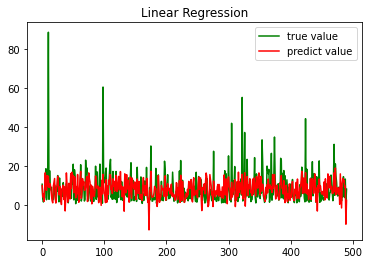

In [37]:
plt.figure()
result = mlr_final.predict(X_test)
plt.plot(np.arange(len(result)), y_test,'g-',label='true value')
plt.plot(np.arange(len(result)),result,'r-',label='predict value')
plt.legend()
plt.title('Linear Regression')
plt.show()

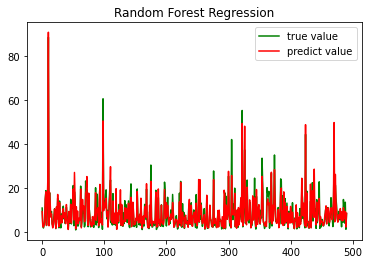

In [38]:
plt.figure()
result = rf_final.predict(X_test)
plt.plot(np.arange(len(result)), y_test,'g-',label='true value')
plt.plot(np.arange(len(result)),result,'r-',label='predict value')
plt.legend()   
plt.title('Random Forest Regression')
plt.show()

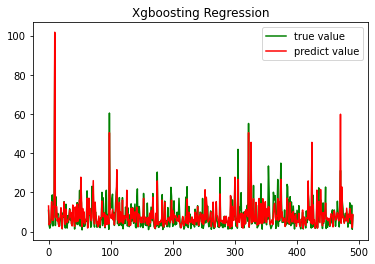

In [39]:
plt.figure()
result = xgb_final.predict(X_test)
plt.plot(np.arange(len(result)), y_test,'g-',label='true value')
plt.plot(np.arange(len(result)),result,'r-',label='predict value')
plt.legend()   
plt.title('Xgboosting Regression')
plt.show()

<a id='ts'></a>
## 3.2 Regression with Time Series
<a href=#top>(back to top)</a>
### Data visualization
In order to apply regression with time series data, we need to plot with historical data to visualize the trend.From the trend we can determine what kind of regression is suitable to implement.

In [40]:
total.head()

Time_stamp boxName     PM 2.5      temp     pressure   humidity  wind_speed  \
0 2018-12-31   iGude  77.372782  7.417218  1032.000000  97.473684    3.000000   
1 2019-01-01   iGude  27.835823  6.492166  1027.291161  84.745234    5.102218   
2 2019-01-02   iGude   2.699040  3.186069  1031.262681  63.092391    5.225036   
3 2019-01-03   iGude  10.160219  0.663960  1035.813869  83.593066    2.287920   
4 2019-01-04   iGude  12.142312  1.665520  1034.075269  86.600358    3.149695   

    latitude  longitude  Time of Day  Peak/NoPeak  Day  Week Day  Weather  \
0  50.100216   8.693827            1            1    0         0        0   
1  50.100216   8.693827            1            1    1         0        0   
2  50.100216   8.693827            1            1    2         0        0   
3  50.100216   8.693827            1            1    3         0        0   
4  50.100216   8.693827            1            1    4         0        0   

   label  
0      0  
1      0  
2      0  
3      0  
4      0

In [41]:
daily_average_PM =  pd.DataFrame(total.groupby('Time_stamp')['PM 2.5'].mean())
daily_average_PM.head()

PM 2.5
Time_stamp            
2018-12-31  102.788295
2019-01-01   25.625107
2019-01-02    2.849617
2019-01-03   10.738730
2019-01-04   14.311634

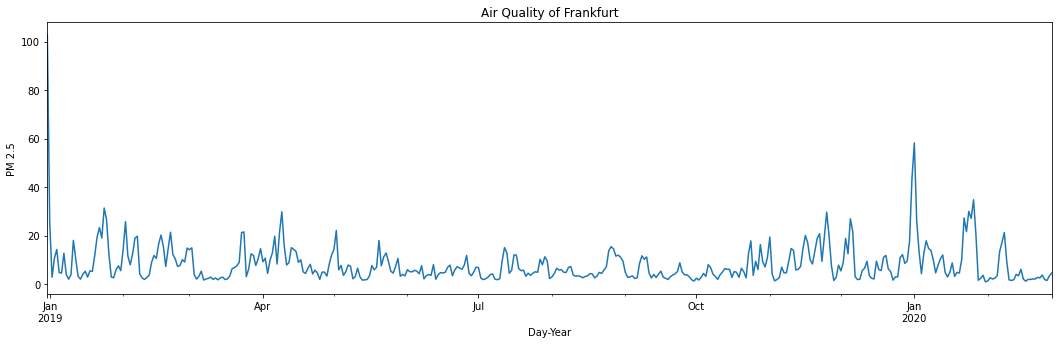

In [42]:
daily_average_PM.plot(title='Air Quality of Frankfurt', legend=False, figsize=(18,5))
plt.xlabel('Day-Year'); plt.ylabel('PM 2.5');

<a id='cm'></a>
## 3.3 Classification Model
<a href=#top>(back to top)</a>
### Data preprocessing
In order to apply classification model in this dataset, we first need to change our target PM 2.5 which is continous, into categorical. From World Health Organization (WHO) we find out the air quality guidelines and interim targets for PM 2.5:
1. Interim target-1(IT-1): PM 2.5 = 35 ug/m^3 It is associated with about a 15% gigher long-term mortality risk relative to AQG level.
2. Interim target-2(IT-2): PM 2.5 = 25 ug/m^3 In addition to other health benefits, this lebel lower the risk of premature mortality bu approximately 6% [2-11%] relative to the IT-1 level.
3. Interim target-3(IT-3): PM 2.5 = 15 ug/m^3 In addition to other health benefits, this level reduced the mortality risk by approximately 6% [2-11%] relative to the -IT-2 level.
4. Air quality guideline (AQG): PM 2.5 = 10 ug/m^3 These are the lowest levels at which total, cardiopulmonary and lung cancer mortality have been shown to increase with more than 95% confidence in response to long-term exposure to PM2.5

In [43]:
total.head()

Time_stamp boxName     PM 2.5      temp     pressure   humidity  wind_speed  \
0 2018-12-31   iGude  77.372782  7.417218  1032.000000  97.473684    3.000000   
1 2019-01-01   iGude  27.835823  6.492166  1027.291161  84.745234    5.102218   
2 2019-01-02   iGude   2.699040  3.186069  1031.262681  63.092391    5.225036   
3 2019-01-03   iGude  10.160219  0.663960  1035.813869  83.593066    2.287920   
4 2019-01-04   iGude  12.142312  1.665520  1034.075269  86.600358    3.149695   

    latitude  longitude  Time of Day  Peak/NoPeak  Day  Week Day  Weather  \
0  50.100216   8.693827            1            1    0         0        0   
1  50.100216   8.693827            1            1    1         0        0   
2  50.100216   8.693827            1            1    2         0        0   
3  50.100216   8.693827            1            1    3         0        0   
4  50.100216   8.693827            1            1    4         0        0   

   label  
0      0  
1      0  
2      0  
3      0  
4      0

In [44]:
for i in range(0,len(total.index)):
    if total.loc[i,'PM 2.5']<=10:
        total.loc[i,'PM 2.5 level']= 'AQG'
    elif total.loc[i,'PM 2.5']<=15:
        total.loc[i,'PM 2.5 level']= 'IT-3'
    elif total.loc[i,'PM 2.5']<=25:
        total.loc[i,'PM 2.5 level']= 'IT-2'
    elif total.loc[i,'PM 2.5']<=35:
        total.loc[i,'PM 2.5 level']= 'IT-1'
    else:
        total.loc[i,'PM 2.5 level']= 'exceed standard'
total.head()

Time_stamp boxName     PM 2.5      temp     pressure   humidity  wind_speed  \
0 2018-12-31   iGude  77.372782  7.417218  1032.000000  97.473684    3.000000   
1 2019-01-01   iGude  27.835823  6.492166  1027.291161  84.745234    5.102218   
2 2019-01-02   iGude   2.699040  3.186069  1031.262681  63.092391    5.225036   
3 2019-01-03   iGude  10.160219  0.663960  1035.813869  83.593066    2.287920   
4 2019-01-04   iGude  12.142312  1.665520  1034.075269  86.600358    3.149695   

    latitude  longitude  Time of Day  Peak/NoPeak  Day  Week Day  Weather  \
0  50.100216   8.693827            1            1    0         0        0   
1  50.100216   8.693827            1            1    1         0        0   
2  50.100216   8.693827            1            1    2         0        0   
3  50.100216   8.693827            1            1    3         0        0   
4  50.100216   8.693827            1            1    4         0        0   

   label     PM 2.5 level  
0      0  exceed standard  
1      0             IT-1  
2      0              AQG  
3      0             IT-3  
4      0             IT-3

In [45]:
total['PM 2.5 level'].value_counts()

AQG                1765
IT-3                341
IT-2                261
IT-1                 59
exceed standard      29
Name: PM 2.5 level, dtype: int64

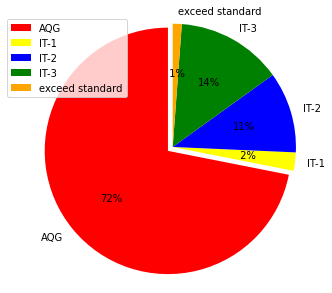

In [46]:
plt.figure(figsize=(5,5))
labels = [u'AQG', u'IT-1', u'IT-2', u'IT-3',u'exceed standard']
sizes = [1765, 59, 261, 341, 29]
colors = ['red', 'yellow', 'blue', 'green','orange']
explode = (0.05, 0, 0, 0,0)

patches, l_text, p_text = plt.pie(sizes, explode=explode, labels=labels, colors=colors,
                                       labeldistance=1.1, autopct='%2.0f%%', shadow=False,
                                       startangle=90, pctdistance=0.6)
plt.axis('equal')
plt.legend(loc='upper left', bbox_to_anchor=(-0.1, 1))
plt.grid()
plt.show()

#### 1.Using all features for modeling

In [47]:
# define X as the features we use in classification model, y is the target.
X1=total[['temp','pressure','humidity','wind_speed','Time of Day','Peak/NoPeak','Day','Week Day','Weather']]
y=total['PM 2.5 level']
X1

temp     pressure   humidity  wind_speed  Time of Day  Peak/NoPeak  \
0     7.417218  1032.000000  97.473684    3.000000            1            1   
1     6.492166  1027.291161  84.745234    5.102218            1            1   
2     3.186069  1031.262681  63.092391    5.225036            1            1   
3     0.663960  1035.813869  83.593066    2.287920            1            1   
4     1.665520  1034.075269  86.600358    3.149695            1            1   
...        ...          ...        ...         ...          ...          ...   
2450  7.522438  1015.946996  78.621908    4.820495            1            1   
2451  8.242347  1001.173285  80.039711    6.968592            1            1   
2452  3.862821   999.396429  70.046429    6.943929            1            1   
2453  2.490605  1001.064057  85.640569    5.070463            1            1   
2454  3.866435  1014.953704  66.995370    4.954167            2            1   

      Day  Week Day  Weather  
0       0         0        0  
1       1         0        0  
2       2         0        0  
3       3         0        0  
4       4         0        0  
...   ...       ...      ...  
2450    0         0        0  
2451    1         0        3  
2452    2         0        0  
2453    3         0        0  
2454    4         0        0  

[2455 rows x 9 columns]

In [48]:
# transform all the categorical features back into 'object' type
X1['Time of Day'].replace(Time_of_day_dict, inplace=True)
X1['Peak/NoPeak'].replace(peak_dict,inplace=True)
X1['Day'].replace(Day_dict,inplace=True)
X1['Week Day'].replace(Weekday_dict,inplace=True)
X1['Weather'].replace(Weather_dict,inplace=True)
X1

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


temp     pressure   humidity  wind_speed    Time of Day Peak/NoPeak  \
0     7.417218  1032.000000  97.473684    3.000000    Night_Hours     No_Peak   
1     6.492166  1027.291161  84.745234    5.102218    Night_Hours     No_Peak   
2     3.186069  1031.262681  63.092391    5.225036    Night_Hours     No_Peak   
3     0.663960  1035.813869  83.593066    2.287920    Night_Hours     No_Peak   
4     1.665520  1034.075269  86.600358    3.149695    Night_Hours     No_Peak   
...        ...          ...        ...         ...            ...         ...   
2450  7.522438  1015.946996  78.621908    4.820495    Night_Hours     No_Peak   
2451  8.242347  1001.173285  80.039711    6.968592    Night_Hours     No_Peak   
2452  3.862821   999.396429  70.046429    6.943929    Night_Hours     No_Peak   
2453  2.490605  1001.064057  85.640569    5.070463    Night_Hours     No_Peak   
2454  3.866435  1014.953704  66.995370    4.954167  Morning_Hours     No_Peak   

            Day Week Day Weather  
0        Monday  Workday  Clouds  
1       Tuesday  Workday  Clouds  
2     Wednesday  Workday  Clouds  
3      Thursday  Workday  Clouds  
4        Friday  Workday  Clouds  
...         ...      ...     ...  
2450     Monday  Workday  Clouds  
2451    Tuesday  Workday    Rain  
2452  Wednesday  Workday  Clouds  
2453   Thursday  Workday  Clouds  
2454     Friday  Workday  Clouds  

[2455 rows x 9 columns]

#### 2.Using useful features for modeling 

In [49]:
# define X2 as the features we use in classification model, y is the target.
X2=total[['temp','pressure','humidity','wind_speed','Day','Week Day','Weather']]
y=total['PM 2.5 level']
X2.head()

temp     pressure   humidity  wind_speed  Day  Week Day  Weather
0  7.417218  1032.000000  97.473684    3.000000    0         0        0
1  6.492166  1027.291161  84.745234    5.102218    1         0        0
2  3.186069  1031.262681  63.092391    5.225036    2         0        0
3  0.663960  1035.813869  83.593066    2.287920    3         0        0
4  1.665520  1034.075269  86.600358    3.149695    4         0        0

In [50]:
# transform all the categorical features back into 'object' type
X2['Day'].replace(Day_dict,inplace=True)
X2['Week Day'].replace(Weekday_dict,inplace=True)
X2['Weather'].replace(Weather_dict,inplace=True)
X2

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


temp     pressure   humidity  wind_speed        Day Week Day Weather
0     7.417218  1032.000000  97.473684    3.000000     Monday  Workday  Clouds
1     6.492166  1027.291161  84.745234    5.102218    Tuesday  Workday  Clouds
2     3.186069  1031.262681  63.092391    5.225036  Wednesday  Workday  Clouds
3     0.663960  1035.813869  83.593066    2.287920   Thursday  Workday  Clouds
4     1.665520  1034.075269  86.600358    3.149695     Friday  Workday  Clouds
...        ...          ...        ...         ...        ...      ...     ...
2450  7.522438  1015.946996  78.621908    4.820495     Monday  Workday  Clouds
2451  8.242347  1001.173285  80.039711    6.968592    Tuesday  Workday    Rain
2452  3.862821   999.396429  70.046429    6.943929  Wednesday  Workday  Clouds
2453  2.490605  1001.064057  85.640569    5.070463   Thursday  Workday  Clouds
2454  3.866435  1014.953704  66.995370    4.954167     Friday  Workday  Clouds

[2455 rows x 7 columns]

#### 3.Slipting training set and test set

In [51]:
#split training and test data, and make the proportion of y in training set and test set are the same.
X_train,X_test,y_train,y_test = train_test_split(X2,y,test_size=0.3,random_state=42,stratify=y)
y_train.value_counts(normalize=True)

AQG                0.718859
IT-3               0.139115
IT-2               0.106519
IT-1               0.023865
exceed standard    0.011641
Name: PM 2.5 level, dtype: float64

In [52]:
y_test.value_counts(normalize=True)

AQG                0.719132
IT-3               0.138399
IT-2               0.105834
IT-1               0.024423
exceed standard    0.012212
Name: PM 2.5 level, dtype: float64

#### 4.Making pipeline (scaling and onehot encoding)

In [53]:
# by fitting X_train, we use a pipeline to scale numerical features and one hot encode categorical features in X_train and X_test
ct = ColumnTransformer([
    ('scale',StandardScaler(),
    make_column_selector(dtype_include=np.number)),
    ('onehot',OneHotEncoder(drop='first'),    # for onehot encoding, we drop each categorical features first column.
    make_column_selector(dtype_include=object))
])

In [54]:
ct.fit(X_train)
X_ttrain=ct.transform(X_train)
X_ttest=ct.transform(X_test)
X_train.iloc[:3]

temp     pressure   humidity  wind_speed       Day Week Day Weather
407  6.497273  1010.589161  80.648601    4.945105  Thursday  Workday  Clouds
396  3.027304  1035.485217  83.546087    2.821217    Sunday  Weekend  Clouds
417  7.544137  1011.051233  71.470588    6.361480    Sunday  Weekend  Clouds

In [55]:
X_ttrain[:3]

array([[-0.50203245, -0.46380747,  0.3974748 ,  0.72160104,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.9946537 ,  1.95354932,  0.60210024, -0.52963248,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.35341225, -0.41894116, -0.25069239,  1.55602192,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]])

### Modeling 
### 1.DNN model

In [56]:
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical

In [57]:
# change target (y_train,y_test) into onehot code.
y_train_encode=pd.get_dummies(y_train)
y_test_encode=pd.get_dummies(y_test)
y_test_encode

AQG  IT-1  IT-2  IT-3  exceed standard
2103    1     0     0     0                0
554     1     0     0     0                0
1974    1     0     0     0                0
529     0     0     0     1                0
1055    0     0     0     1                0
...   ...   ...   ...   ...              ...
2422    1     0     0     0                0
2253    1     0     0     0                0
1464    1     0     0     0                0
2241    1     0     0     0                0
2150    0     0     0     1                0

[737 rows x 5 columns]

#### Modeling

In [58]:
n_cols=X_ttrain.shape[1] #find number of node in input layer
model=Sequential()
model.add(Dense(100,activation='relu',input_shape=(n_cols,)))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(5,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [59]:
early_stopping_monitor=EarlyStopping(patience=2)        #set a early stop to prevent overfitting
record=model.fit(X_ttrain,y_train_encode,validation_split=0.2,epochs=50,callbacks=[early_stopping_monitor])   #20% of data would be used for validation

Epoch 1/50
43/43 [==============================] - 0s 6ms/step - loss: 0.9647 - categorical_accuracy: 0.6965 - val_loss: 0.8227 - val_categorical_accuracy: 0.7355
Epoch 2/50
43/43 [==============================] - 0s 2ms/step - loss: 0.7067 - categorical_accuracy: 0.7496 - val_loss: 0.7826 - val_categorical_accuracy: 0.7297
Epoch 3/50
43/43 [==============================] - 0s 2ms/step - loss: 0.6681 - categorical_accuracy: 0.7598 - val_loss: 0.7504 - val_categorical_accuracy: 0.7297
Epoch 4/50
43/43 [==============================] - 0s 2ms/step - loss: 0.6414 - categorical_accuracy: 0.7620 - val_loss: 0.7362 - val_categorical_accuracy: 0.7326
Epoch 5/50
43/43 [==============================] - 0s 2ms/step - loss: 0.6165 - categorical_accuracy: 0.7664 - val_loss: 0.7137 - val_categorical_accuracy: 0.7297
Epoch 6/50
43/43 [==============================] - 0s 2ms/step - loss: 0.5963 - categorical_accuracy: 0.7693 - val_loss: 0.7086 - val_categorical_accuracy: 0.7297
Epoch 7/50
43/43

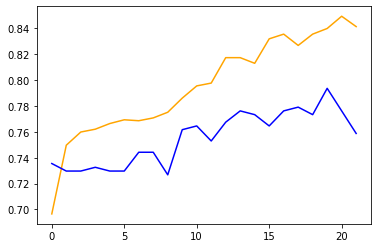

In [60]:
# Plot accuracy change vs validation accuracy change based on epochs
plt.plot(record.epoch, record.history.get('categorical_accuracy'),color='orange')
plt.plot(record.epoch, record.history.get('val_categorical_accuracy'),color='blue')

In [61]:
# output the test prediction results
y_test_pred = model.predict(X_ttest)

y_test_pred[:10]

array([[9.9782526e-01, 9.9341858e-05, 1.0951344e-03, 9.7921304e-04,
        1.1291291e-06],
       [8.1720990e-01, 3.2001848e-03, 6.7435190e-02, 1.1184040e-01,
        3.1431668e-04],
       [9.3590844e-01, 1.6860616e-03, 2.6944844e-02, 3.5386138e-02,
        7.4609510e-05],
       [2.1902105e-01, 3.0271173e-02, 3.8005039e-01, 3.6970067e-01,
        9.5677684e-04],
       [6.5685576e-01, 2.7307330e-03, 1.3333493e-01, 2.0693617e-01,
        1.4242349e-04],
       [8.7743241e-01, 9.5859513e-04, 4.8352934e-02, 7.3239557e-02,
        1.6432656e-05],
       [7.3561525e-01, 6.2273439e-02, 1.7640930e-01, 2.5491994e-02,
        2.0992651e-04],
       [5.9832132e-01, 8.0935919e-04, 6.7341230e-03, 3.9411452e-01,
        2.0677666e-05],
       [1.0003309e-01, 6.7526765e-02, 6.9802046e-01, 1.3357264e-01,
        8.4708963e-04],
       [2.3796651e-01, 2.8984562e-02, 5.3140849e-01, 2.0148590e-01,
        1.5455189e-04]], dtype=float32)

In [62]:
# convert probabilities to labels
y_test_pred=np.argmax(y_test_pred, axis=1)

labels=['AQG', 'IT-3', 'IT-2', 'IT-1', 'exceed standard']
y_test_pred_dnn=[]
for item in y_test_pred:
    y_test_pred_dnn.append(labels[item])
    
np.array(y_test_pred_dnn)[:10]

array(['AQG', 'AQG', 'AQG', 'IT-2', 'AQG', 'AQG', 'AQG', 'AQG', 'IT-2',
       'IT-2'], dtype='<U15')

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2000      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 22,705
Trainable params: 22,705
Non-trainable params: 0
_________________________________________________________________


In [64]:
_,dnn_accuracy=model.evaluate(X_ttest,y_test_encode)

24/24 [==============================] - 0s 1ms/step - loss: 0.5933 - categorical_accuracy: 0.7680


In [65]:
print('Accuracy on test data of deep neural network is ',dnn_accuracy)

Accuracy on test data of deep neural network is  0.767978310585022


confusion matrix and classification report

In [66]:
from sklearn.metrics import confusion_matrix

C_dnn=confusion_matrix(
    np.array(y_test),   # array, Gound true (correct) target values
    np.array(y_test_pred_dnn),  # array, Estimated targets as returned by a classifier
    labels=['AQG', 'IT-3', 'IT-2', 'IT-1', 'exceed standard'],  # array, List of labels to index the matrix.
    sample_weight=None  # array-like of shape = [n_samples], Optional sample weights
)

def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # normalization
    plt.imshow(cm, interpolation='nearest')    
    plt.title(title)    
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    
    plt.yticks(num_local, labels_name)    
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')

In [67]:
col_name=pd.MultiIndex.from_product([['Predicted label'], labels])
row_name=pd.MultiIndex.from_product([['True label'], labels])
pd.DataFrame(C_dnn,columns=col_name,index=row_name)

Predicted label                               
                                       AQG IT-3 IT-2 IT-1 exceed standard
True label AQG                         500    0   25    5               0
           IT-3                         53    0   37   12               0
           IT-2                         11    8   49   10               0
           IT-1                          4    0   13    0               1
           exceed standard               1    2    1    0               5

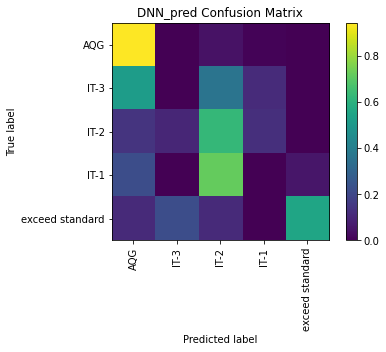

In [68]:
plot_confusion_matrix(C_dnn, labels, "DNN_pred Confusion Matrix")

plt.show()

In [69]:
from sklearn.metrics import classification_report  
print('classification_report:')  
print (classification_report(y_test, y_test_pred_dnn))

classification_report:
                 precision    recall  f1-score   support

            AQG       0.88      0.94      0.91       530
           IT-1       0.00      0.00      0.00        18
           IT-2       0.39      0.63      0.48        78
           IT-3       0.00      0.00      0.00       102
exceed standard       0.83      0.56      0.67         9

       accuracy                           0.75       737
      macro avg       0.42      0.43      0.41       737
   weighted avg       0.68      0.75      0.71       737



### 2.KNN model
#### Hyperparameter tuning

In [70]:
k_range = list(range(1,20))
weight_options = ['uniform','distance'] # Uniform (equal weight), distance (weight and distance are inversely proportional, the closer it is, the stronger the influence)
algorithm_options = ['auto','ball_tree','kd_tree','brute'] # Different kinds of formations of trees
param_grid = dict(n_neighbors = k_range,weights = weight_options,algorithm=algorithm_options)

knn=KNeighborsClassifier()
knn_cv=GridSearchCV(knn,param_grid,scoring='accuracy',cv=5)
knn_cv.fit(X_ttrain,np.array(y_train).ravel())
print(knn_cv.best_params_) # find best hyperparameter n_neighbor.
print(knn_cv.best_score_)  # find the score of the best hyperparameter.

{'algorithm': 'auto', 'n_neighbors': 13, 'weights': 'distance'}
0.8277086582141162


In [71]:
knn_accuracy=knn_cv.score(X_ttest,y_test)
print('Accuracy on test data of knn is ',knn_accuracy)

Accuracy on test data of knn is  0.8181818181818182


#### Modeling

In [72]:
y_test_pred_knn=knn_cv.predict(X_ttest)
y_test_pred_knn[:10]

array(['AQG', 'AQG', 'AQG', 'IT-3', 'IT-3', 'AQG', 'AQG', 'IT-3', 'IT-3',
       'AQG'], dtype=object)

In [73]:
C_knn=confusion_matrix(
    np.array(y_test),   
    np.array(y_test_pred_knn),  
    sample_weight=None  
)

In [74]:
pd.DataFrame(C_knn,columns=col_name,index=row_name)

Predicted label                               
                                       AQG IT-3 IT-2 IT-1 exceed standard
True label AQG                         501    0    5   24               0
           IT-3                          1    2   13    0               2
           IT-2                          5   12   44   17               0
           IT-1                         34    0   17   51               0
           exceed standard               0    4    0    0               5

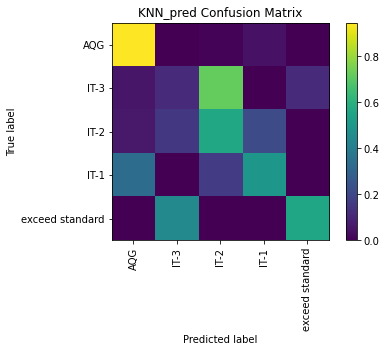

In [75]:
plot_confusion_matrix(C_knn, labels, "KNN_pred Confusion Matrix")
plt.show()

In [76]:
print('classification_report:')  
print (classification_report(y_test, y_test_pred_knn))

classification_report:
                 precision    recall  f1-score   support

            AQG       0.93      0.95      0.94       530
           IT-1       0.11      0.11      0.11        18
           IT-2       0.56      0.56      0.56        78
           IT-3       0.55      0.50      0.53       102
exceed standard       0.71      0.56      0.63         9

       accuracy                           0.82       737
      macro avg       0.57      0.54      0.55       737
   weighted avg       0.81      0.82      0.82       737



### 3. Decision Tree
#### Preprocessing data

In [77]:
# transform y_train, y_test into dataframe
y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)
y_train.head()

PM 2.5 level
407           AQG
396           AQG
417           AQG
70           IT-2
1044          AQG

In [78]:
# using ordinal encoder to transform y_train, y_test
oe=OrdinalEncoder()
oe.fit(y_train)
y_train_ordinal=oe.transform(y_train)
y_test_ordinal=oe.transform(y_test)
y_train_ordinal[0:5]

array([[0.],
       [0.],
       [0.],
       [2.],
       [0.]])

#### Modeling

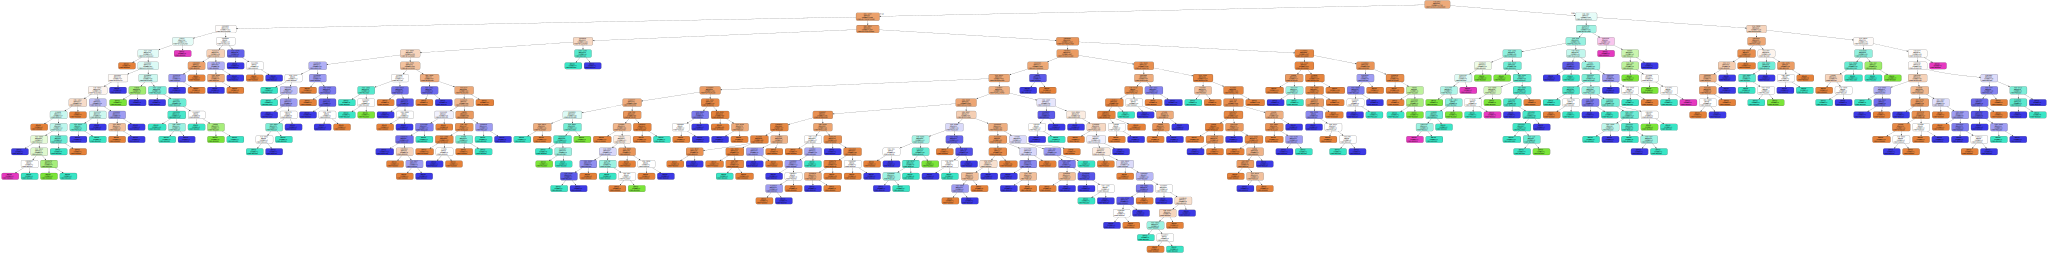

In [79]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_ttrain,y_train_ordinal)
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None,
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = graphviz.Source(dot_data)  
graph 

In [80]:
clf_accuracy=clf.score(X_ttest,y_test_ordinal)
print('Accuracy on test data of decision tree is ',clf_accuracy)

Accuracy on test data of decision tree is  0.7951153324287653


confusion matrix and classification report

In [81]:
y_test_pred_clf=clf.predict(X_ttest)

C_clf=confusion_matrix(
    np.array(y_test_ordinal),   
    np.array(y_test_pred_clf),  
    sample_weight=None  
)
pd.DataFrame(C_clf,columns=col_name,index=row_name)

Predicted label                               
                                       AQG IT-3 IT-2 IT-1 exceed standard
True label AQG                         478    1    9   42               0
           IT-3                          0    7    9    0               2
           IT-2                          3   15   42   18               0
           IT-1                         30    0   18   54               0
           exceed standard               0    3    0    1               5

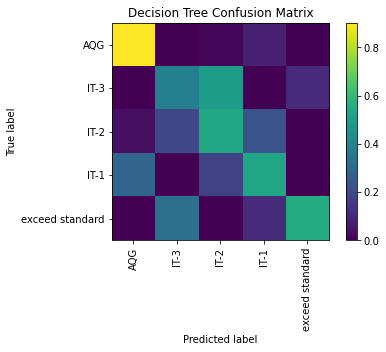

In [82]:
plot_confusion_matrix(C_clf, labels, "Decision Tree Confusion Matrix")
plt.show()

In [83]:
print('classification_report:')  
print (classification_report(y_test_ordinal, y_test_pred_clf))

classification_report:
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92       530
         1.0       0.27      0.39      0.32        18
         2.0       0.54      0.54      0.54        78
         3.0       0.47      0.53      0.50       102
         4.0       0.71      0.56      0.63         9

    accuracy                           0.80       737
   macro avg       0.59      0.58      0.58       737
weighted avg       0.81      0.80      0.80       737



### 4.Random Forest Model

#### Modeling

In [84]:
rfc = RandomForestClassifier()
tuned_parameters = [{'min_samples_leaf':[1,2,3,4,5], 'n_estimators':[50,100,150,200]}]
rfc_cv = GridSearchCV(estimator=rfc,param_grid=tuned_parameters, cv=5, n_jobs=1)
rfc_cv.fit(X_ttrain,np.array(y_train).ravel())

print(rfc_cv.best_params_) #find the best parameters
print(rfc_cv.best_score_)  #find the score of best parameters
# Obviously, the smaller the min_samples_leaf and the bigger the n_estimators, the better the result.

{'min_samples_leaf': 1, 'n_estimators': 100}
0.8242101159400637


In [85]:
rfc_accuracy=rfc_cv.score(X_ttest,y_test)
print('Accuracy on test data of random forest is ',rfc_accuracy)

Accuracy on test data of random forest is  0.8317503392130258


confusion matrix and classification report

In [86]:
y_test_pred_rfc=rfc_cv.predict(X_ttest)

C_rfc=confusion_matrix(
    np.array(y_test),   
    np.array(y_test_pred_rfc),  
    sample_weight=None  
)
pd.DataFrame(C_rfc,columns=col_name,index=row_name)

Predicted label                               
                                       AQG IT-3 IT-2 IT-1 exceed standard
True label AQG                         504    0    2   24               0
           IT-3                          1    5   11    0               1
           IT-2                          5   11   47   15               0
           IT-1                         30    0   20   52               0
           exceed standard               0    4    0    0               5

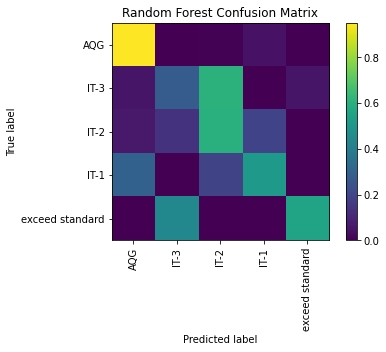

In [87]:
plot_confusion_matrix(C_rfc, labels, "Random Forest Confusion Matrix")
plt.show()

In [88]:
print('classification_report:')  
print (classification_report(y_test, y_test_pred_rfc))

classification_report:
                 precision    recall  f1-score   support

            AQG       0.93      0.95      0.94       530
           IT-1       0.25      0.28      0.26        18
           IT-2       0.59      0.60      0.59        78
           IT-3       0.57      0.51      0.54       102
exceed standard       0.83      0.56      0.67         9

       accuracy                           0.83       737
      macro avg       0.64      0.58      0.60       737
   weighted avg       0.83      0.83      0.83       737



### 5. Support Vector Machine (SVM)
#### Model 1: SVM.SVC(kernel='linear')
#### hyperparameter tuning

In [89]:
param_grid={'C':np.arange(0.1,10,0.1)}
model1=svm.SVC(kernel='linear')
model1_cv=GridSearchCV(model1,param_grid,scoring='accuracy',cv=5)
model1_cv.fit(X_ttrain,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/con

GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='accuracy')

In [90]:
print(model1_cv.best_params_) # find best hyperparameter.
print(model1_cv.best_score_)  # find the score of the best hyperparameter.

{'C': 8.6}
0.7374872872737135


#### Modeling

In [91]:
y_test_pred_svm1=model1_cv.predict(X_ttest)
# find the accuracy on test data
svm1_accuracy=model1_cv.score(X_ttest,y_test)
print('svm with linear kernel model accuracy on test data is',svm1_accuracy)

svm with linear kernel model accuracy on test data is 0.7327001356852103


confusion matrix and classification report

In [92]:
C_svm1=confusion_matrix(
    np.array(y_test),   
    np.array(y_test_pred_svm1),  
    sample_weight=None  
)
pd.DataFrame(C_svm1,columns=col_name,index=row_name)

Predicted label                               
                                       AQG IT-3 IT-2 IT-1 exceed standard
True label AQG                         530    0    0    0               0
           IT-3                         12    2    1    0               3
           IT-2                         72    1    3    0               2
           IT-1                        100    0    2    0               0
           exceed standard               2    2    0    0               5

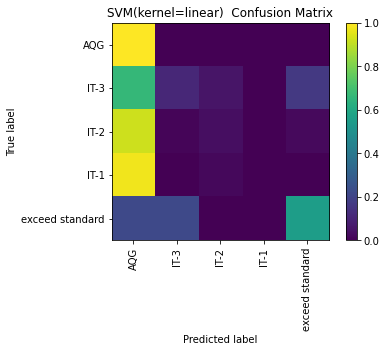

In [93]:
plot_confusion_matrix(C_svm1, labels, "SVM(kernel=linear)  Confusion Matrix")
plt.show()

In [94]:
print('classification_report:')  
print (classification_report(y_test, y_test_pred_svm1))

classification_report:
                 precision    recall  f1-score   support

            AQG       0.74      1.00      0.85       530
           IT-1       0.40      0.11      0.17        18
           IT-2       0.50      0.04      0.07        78
           IT-3       0.00      0.00      0.00       102
exceed standard       0.50      0.56      0.53         9

       accuracy                           0.73       737
      macro avg       0.43      0.34      0.32       737
   weighted avg       0.60      0.73      0.63       737



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Model 2: SVM.LinearSVC
#### hyperparameter tuning

In [95]:
param_grid={'C':np.arange(0.1,10,0.1)}
model2=svm.LinearSVC(max_iter=10000)
model2_cv=GridSearchCV(model2,param_grid,scoring='accuracy',cv=5)
model2_cv.fit(X_ttrain,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/con

GridSearchCV(cv=5, estimator=LinearSVC(max_iter=10000),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='accuracy')

In [96]:
print(model2_cv.best_params_) # find best hyperparameter.
print(model2_cv.best_score_)  # find the score of the best hyperparameter.

{'C': 1.1}
0.7421435351549257


#### Modeling

In [97]:
y_test_pred_svm2=model2_cv.predict(X_ttest)
# find the accuracy on test data
svm2_accuracy=model2_cv.score(X_ttest,y_test)
print('svm.SVC linear model accuracy on test data is',svm2_accuracy)

svm.SVC linear model accuracy on test data is 0.728629579375848


confusion matrix and classification report

In [98]:
C_svm2=confusion_matrix(
    np.array(y_test),   
    np.array(y_test_pred_svm2),  
    sample_weight=None  
)
pd.DataFrame(C_svm2,columns=col_name,index=row_name)

Predicted label                               
                                       AQG IT-3 IT-2 IT-1 exceed standard
True label AQG                         521    0    7    2               0
           IT-3                         13    2    1    2               0
           IT-2                         62    1   12    3               0
           IT-1                         96    0    6    0               0
           exceed standard               5    2    0    0               2

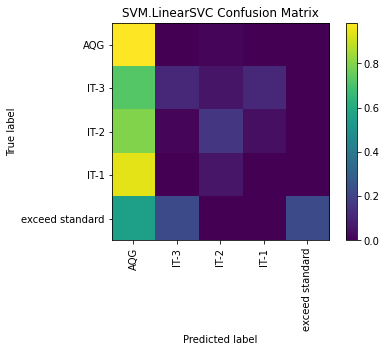

In [99]:
plot_confusion_matrix(C_svm2, labels, "SVM.LinearSVC Confusion Matrix")
plt.show()

In [100]:
print('classification_report:')  
print (classification_report(y_test, y_test_pred_svm2))

classification_report:
                 precision    recall  f1-score   support

            AQG       0.75      0.98      0.85       530
           IT-1       0.40      0.11      0.17        18
           IT-2       0.46      0.15      0.23        78
           IT-3       0.00      0.00      0.00       102
exceed standard       1.00      0.22      0.36         9

       accuracy                           0.73       737
      macro avg       0.52      0.29      0.32       737
   weighted avg       0.61      0.73      0.64       737



#### Model 3: SVM.SVC(kernel='rbf')
#### hyperparameter tuning

In [101]:
param_grid={'C':np.arange(0.1,10,0.1)}
model3=svm.SVC(kernel='rbf',gamma='scale')
model3_cv=GridSearchCV(model3,param_grid,scoring='accuracy',cv=3)
model3_cv.fit(X_ttrain,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/con

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='accuracy')

In [102]:
print(model3_cv.best_params_) # find best hyperparameter.
print(model3_cv.best_score_)  # find the score of the best hyperparameter.

{'C': 9.700000000000001}
0.7712434453272149


#### Modeling

In [103]:
y_test_pred_svm3=model3_cv.predict(X_ttest)
# find the accuracy on test data
svm3_accuracy=model3_cv.score(X_ttest,y_test)
print('svm with rbf kernel model when C=9.7 accuracy on test data is',svm3_accuracy)

svm with rbf kernel model when C=9.7 accuracy on test data is 0.7896879240162822


confusion matrix and classification report

In [104]:
C_svm3=confusion_matrix(
    np.array(y_test),   
    np.array(y_test_pred_svm3),  
    sample_weight=None  
)
pd.DataFrame(C_svm3,columns=col_name,index=row_name)

Predicted label                               
                                       AQG IT-3 IT-2 IT-1 exceed standard
True label AQG                         512    0    8   10               0
           IT-3                          5    3    7    1               2
           IT-2                         20   12   33   13               0
           IT-1                         51    0   22   29               0
           exceed standard               1    3    0    0               5

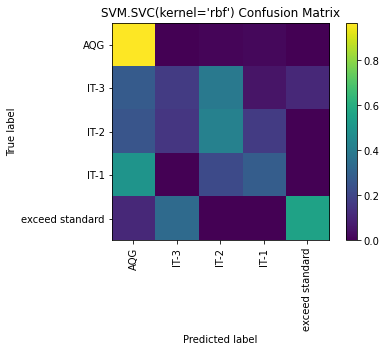

In [105]:
plot_confusion_matrix(C_svm3, labels, "SVM.SVC(kernel='rbf') Confusion Matrix")
plt.show()

In [106]:
print('classification_report:')  
print (classification_report(y_test, y_test_pred_svm3))

classification_report:
                 precision    recall  f1-score   support

            AQG       0.87      0.97      0.92       530
           IT-1       0.17      0.17      0.17        18
           IT-2       0.47      0.42      0.45        78
           IT-3       0.55      0.28      0.37       102
exceed standard       0.71      0.56      0.63         9

       accuracy                           0.79       737
      macro avg       0.55      0.48      0.51       737
   weighted avg       0.76      0.79      0.77       737



#### Model 4: SVM.SVC(kernel='poly')
#### hyperparameter tuning

In [107]:
param_grid={'C':np.arange(0.1,10,0.1),'degree':np.arange(2,5)}
model4=svm.SVC(kernel='poly',gamma='scale')
model4_cv=GridSearchCV(model4,param_grid,scoring='accuracy',cv=3)
model4_cv.fit(X_ttrain,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/con

GridSearchCV(cv=3, estimator=SVC(kernel='poly'),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]),
                         'degree': array([2, 3, 4])},
             scoring='accuracy')

In [108]:
print(model4_cv.best_params_) # find best hyperparameter.
print(model4_cv.best_score_)  # find the score of the best hyperparameter.

{'C': 3.0000000000000004, 'degree': 4}
0.7753135462559545


#### Modeling

In [109]:
y_test_pred_svm4=model4_cv.predict(X_ttest)
# find the accuracy on test data
svm4_accuracy=model4_cv.score(X_ttest,y_test)
print('Accuracy on test data of SVM.SVC with kernel=poly when C=3, degree=4 is ',svm4_accuracy)

Accuracy on test data of SVM.SVC with kernel=poly when C=3, degree=4 is  0.7761194029850746


confusion matrix and classification report

In [110]:
C_svm4=confusion_matrix(
    np.array(y_test),   
    np.array(y_test_pred_svm4),  
    sample_weight=None  
)
pd.DataFrame(C_svm4,columns=col_name,index=row_name)

Predicted label                               
                                       AQG IT-3 IT-2 IT-1 exceed standard
True label AQG                         516    0    9    5               0
           IT-3                          5    3    7    1               2
           IT-2                         27   12   29   10               0
           IT-1                         62    0   21   19               0
           exceed standard               1    3    0    0               5

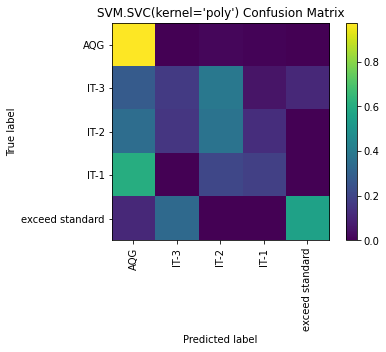

In [111]:
plot_confusion_matrix(C_svm4, labels, "SVM.SVC(kernel='poly') Confusion Matrix")
plt.show()

In [112]:
print('classification_report:')  
print (classification_report(y_test, y_test_pred_svm4))

classification_report:
                 precision    recall  f1-score   support

            AQG       0.84      0.97      0.90       530
           IT-1       0.17      0.17      0.17        18
           IT-2       0.44      0.37      0.40        78
           IT-3       0.54      0.19      0.28       102
exceed standard       0.71      0.56      0.63         9

       accuracy                           0.78       737
      macro avg       0.54      0.45      0.48       737
   weighted avg       0.74      0.78      0.74       737



<a id='clustering'></a>
## 3.4 Clustering Model
<a href=#top>(back to top)</a>

### 1. K-means Clustering Model

For unsupervised learning, we can also use K-means Clustering model to cluster those given features into certain groups. We also apply sihouette score to evaluate the number of cluster.

#### Model Construction

In [113]:
# we set hyperparameter n_cluster = 5
from sklearn.cluster import KMeans
model6= KMeans(n_clusters=5)
model6.fit(X_ttrain)
kmeans_labels=model6.predict(X_ttrain)

#### Crosstable labels vs actual target

In [114]:
grouping1=pd.DataFrame({'kmeans_labels':kmeans_labels,'true lables':pd.Series(y_train['PM 2.5 level'])})
grouping1

kmeans_labels true lables
407               4         AQG
396               1         AQG
417               0         AQG
70                1        IT-2
1044              3         AQG
...             ...         ...
1873              3         AQG
689               4        IT-3
990               4         AQG
1026              3         AQG
715               4         AQG

[1718 rows x 2 columns]

In [115]:
ct1=pd.crosstab(grouping1['kmeans_labels'],grouping1['true lables'])
ct1

true lables    AQG  IT-1  IT-2  IT-3  exceed standard
kmeans_labels                                        
0              181     0     5     5                0
1              118    23    77    79               19
2              217     4    16    45                0
3              362     0    11    60                0
4              357    14    74    50                1

#### evaluate model with sihouette score 

Text(0.5, 0, 'n_clusters')

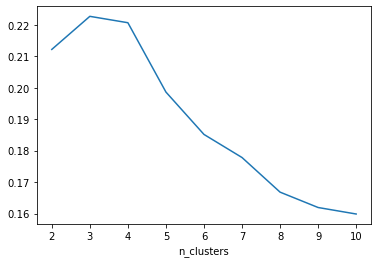

In [116]:
sc_scores = []
clusters = range(2,11)
for i in clusters:  
    model=KMeans(n_clusters=i)
    model.fit(X_ttrain)
    labels = model.predict(X_ttrain).ravel()
    sc_scores.append(silhouette_score(X_ttrain, labels))
plt.plot(clusters, sc_scores)
plt.xlabel('n_clusters')

From sihouette score we can see in Kmeans model, when number of clusters is 3 or 4 it will achieve the highest score, and the score of number of cluster = 5 is also acceptable.

# 2.PCA

In [117]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=3, random_state=42)
X2 = pd.DataFrame(pca.fit_transform(X_ttrain))
SCATTER_SIZE=700
X2['target']=y_train.values
fig = px.scatter_3d(
    X2, 
    x=0, 
    y=1,
    z=2, 
    color='target', 
    title='3d scatter for PCA',
    width=SCATTER_SIZE,
    height=SCATTER_SIZE
)

fig.show()

In [118]:
print(pca.explained_variance_ratio_)

[0.30846431 0.25637591 0.15842074]


In [119]:
pca = PCA(n_components=2) 
X_train_pca = pca.fit_transform(X_ttrain) 
X_test_pca = pca.transform(X_ttest)
X_train_pca_dataframe = pd.DataFrame(X_train_pca)
y_train_pca_dataframe = pd.DataFrame(y_train)
X_train_pca_dataframe.index = y_train_pca_dataframe.index

finalDf = pd.concat([X_train_pca_dataframe, y_train_pca_dataframe], axis = 1)
finalDf.columns = ['Principal Component 1', 'Principal Component 2', 'target']
finalDf

Principal Component 1  Principal Component 2 target
407               -0.400451               0.893183    AQG
396               -1.420012              -1.446754    AQG
417                0.387913               1.291147    AQG
70                -1.150446              -1.291766   IT-2
1044               2.427466              -1.267871    AQG
...                     ...                    ...    ...
1873               2.228861              -1.268966    AQG
689               -0.248813              -0.377042   IT-3
990               -0.620894               1.264391    AQG
1026               0.991054              -0.701761    AQG
715                0.080858               0.302348    AQG

[1718 rows x 3 columns]

In [120]:
fig = px.scatter(
    finalDf, 
    x='Principal Component 1', 
    y='Principal Component 2',
    color="target", 
    title='2d scatter for PCA',
    width=SCATTER_SIZE,
    height=SCATTER_SIZE
)

fig.show()

## show the distribution of k-means clusters after using PCA

In [121]:
train = pd.DataFrame(X_ttrain).copy()
train['cluster'] = kmeans_labels
train

0         1         2         3    4    5    6    7    8    9  \
0    -0.502032 -0.463807  0.397475  0.721601  0.0  0.0  0.0  1.0  0.0  0.0   
1    -0.994654  1.953549  0.602100 -0.529632  0.0  0.0  1.0  0.0  0.0  0.0   
2    -0.353412 -0.418941 -0.250692  1.556022  0.0  0.0  1.0  0.0  0.0  0.0   
3    -0.850959  0.820126  0.201328 -1.499523  0.0  0.0  1.0  0.0  0.0  0.0   
4     1.531414  0.463659 -2.219233 -0.287978  0.0  0.0  0.0  0.0  1.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
1713  1.442794  0.470138 -2.045242 -0.363528  0.0  0.0  0.0  0.0  1.0  0.0   
1714  0.451693 -0.092355  0.545879 -0.754563  1.0  0.0  0.0  0.0  0.0  0.0   
1715  0.041466 -1.414075  1.060502 -0.223641  0.0  0.0  0.0  1.0  0.0  0.0   
1716  1.371086 -0.208961 -0.396921 -0.895282  0.0  0.0  0.0  0.0  0.0  0.0   
1717  0.098195 -0.274108  0.091154  0.139382  0.0  1.0  0.0  0.0  0.0  0.0   

       10   11   12   13   14   15   16   17   18  cluster  
0     1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        4  
1     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        1  
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        1  
4     1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        3  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...      ...  
1713  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        3  
1714  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        4  
1715  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0        4  
1716  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        3  
1717  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        4  

[1718 rows x 20 columns]

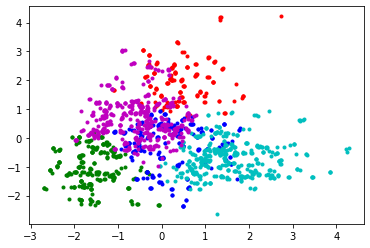

In [122]:
pca = PCA(n_components=5)
new_pca = pd.DataFrame(pca.fit_transform(X_ttrain))
d = new_pca[train['cluster'] == 0]
plt.plot(d[0], d[1], 'r.')
d = new_pca[train['cluster'] == 1]
plt.plot(d[0], d[1], 'g.')
d = new_pca[train['cluster'] == 2]
plt.plot(d[0], d[1], 'b.')
d = new_pca[train['cluster'] == 3]
plt.plot(d[0], d[1], 'c.')
d = new_pca[train['cluster'] == 4]
plt.plot(d[0], d[1], 'm.')

### 3. Hierarchical Clustering model
Apart from Kmeans clustering, we also apply hierachical clustering to cluster the dataset without target. We also apply sihouette score to evaluate the number of clusters.

#### Model Construction

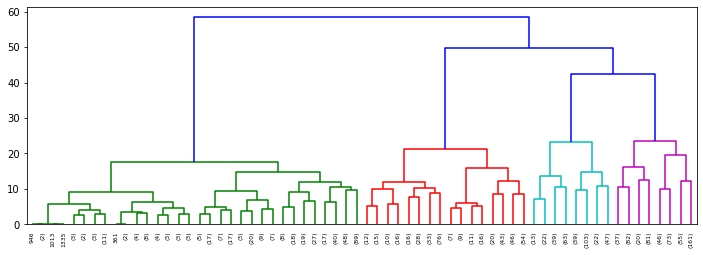

In [123]:
lm1 = linkage(X_ttrain, method='ward')
plt.figure(figsize=(12,4))
dendrogram(lm1, p=5,truncate_mode='level');

In [124]:
# cut the tree by 5 clusters
out=hierarchy.cut_tree(lm1,n_clusters=5).ravel()
grouping2=pd.DataFrame({'hierachical_labels':out,'target':pd.Series(y_train['PM 2.5 level'])})
grouping2

hierachical_labels target
407                    0    AQG
396                    1    AQG
417                    0    AQG
70                     1   IT-2
1044                   2    AQG
...                  ...    ...
1873                   2    AQG
689                    4   IT-3
990                    4    AQG
1026                   2    AQG
715                    4    AQG

[1718 rows x 2 columns]

In [125]:
ct2=pd.crosstab(grouping2['hierachical_labels'],grouping2['target'])
ct2

target              AQG  IT-1  IT-2  IT-3  exceed standard
hierachical_labels                                        
0                   324     0    10    14                0
1                   192    18    80   103               19
2                   340     1    11    51                0
3                   115    19    57    28                1
4                   264     3    25    43                0

#### evaluate model with sihouette score 

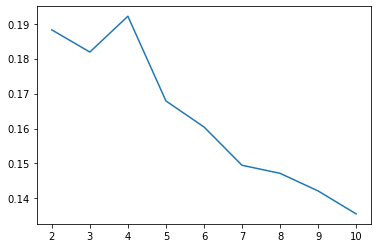

In [126]:
sc_scores = []
clusters = range(2,11)
for i in clusters:  
    labels = hierarchy.cut_tree(lm1, n_clusters=i).ravel()
    sc_scores.append(silhouette_score(X_ttrain, labels))
plt.plot(clusters, sc_scores)

From  above, we can see sihouette score reach a high point when number of clusters is 2 for hierarchical model.